In [36]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py, csv

In [37]:
# Model Definition
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # audio MSM Layers
    self.bigru_audio = keras.layers.Bidirectional(keras.layers.GRU(512))
    self.msl_1_audio = keras.layers.Dense(256, activation='relu')
    self.msl_2_audio = keras.layers.Dense(128, activation='relu')

  def __call__(self, audio_input):
    # audio MSM
    bigru_audio_output = self.bigru_audio(audio_input)
    msl_l1_audio = self.msl_1_audio(bigru_audio_output)
    audio_msm_output = self.msl_2_audio(msl_l1_audio)
    return audio_msm_output

# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 5
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, audio_msm_output):
    output_l1 = self.layer_1(audio_msm_output)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# Sentiment Analysis Model
class SA_Model(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.audio_input = keras.Input(shape=(1, 768))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    audio_msm_output= self.msm(self.audio_input)
    output = self.scm(audio_msm_output)    
    # model definition
    model = keras.Model(inputs=[self.audio_input], outputs=output)
    return model


sa_model = SA_Model()
model = sa_model()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 1024)           │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,261,061 (16.25 MB)

 Trainable params: 4,261,061 (16.25 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [39]:
audio_embeddings = {}

with h5py.File('../../datasets/Dravidian Dataset/malayalam_data/embeddings/audio_embeddings.h5', 'r') as f:
  a_ids = list(f.keys())
  a_max_shape = f[a_ids[0]].shape
  for i in a_ids:
    audio_embeddings[i] = f[i][:]
    shape = f[i].shape
    if a_max_shape < shape:
      a_max_shape = shape
  
  for key,value in audio_embeddings.items():
    padded_value = np.pad(value, ((0, a_max_shape[0] - value.shape[0])), mode='constant')
    reshaped_value = padded_value.reshape((1, padded_value.shape[0]))
    audio_embeddings[key] = reshaped_value

In [40]:
audio_embeddings_list = []
for k in a_ids:
  audio_embeddings_list.append(audio_embeddings[k])
audio_embeddings_array = np.array(audio_embeddings_list)
a_eager_tensor = tf.convert_to_tensor(audio_embeddings_array)
print(a_eager_tensor.shape)

(70, 1, 768)


In [41]:
def convertLabels(label):
  rep = {
    -2 : [1., 0., 0., 0., 0.],
    -1 : [0., 1., 0., 0., 0.],
    0 : [0., 0., 1., 0., 0.],
    1 : [0., 0., 0., 1., 0.],
    2 : [0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[label])

audio_input = a_eager_tensor

labels_dict = {}
labels_list = []
labels_path = '../../datasets/Dravidian Dataset/malayalam_data/labels/labels.csv'
with open(labels_path, newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  # removed MAL_MSA_18 since it has no video file
  for row,k in zip(reader, a_ids):
    labels_dict[k] = convertLabels(int(row['label']))
    labels_list.append(labels_dict[k])
labels_array = np.array(labels_list)
labels_eager_tensor = tf.convert_to_tensor(labels_array)
print(labels_eager_tensor.shape)

label_input = labels_eager_tensor

(70, 5)


In [42]:
audio_train = audio_input[0:55]
label_train = label_input[0:55]

audio_validation = audio_input[49:55]
label_validation = label_input[49:55]

audio_test = audio_input[59:62]
label_test = label_input[59:62]

train_dataset = [audio_train]
validation_data = ([audio_validation], label_validation)
test_dataset = [audio_test]

In [43]:
epochs = 100
history = model.fit(train_dataset, label_train, validation_data=validation_data, epochs=epochs)

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.0000e+00 - loss: 0.3149 - val_accuracy: 0.0000e+00 - val_loss: 0.3195
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.0000e+00 - loss: 0.2864 - val_accuracy: 0.0000e+00 - val_loss: 0.3271
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.0000e+00 - loss: 0.2263 - val_accuracy: 0.0000e+00 - val_loss: 0.3332
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.0000e+00 - loss: 0.2013 - val_accuracy: 0.0000e+00 - val_loss: 0.3333
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.0000e+00 - loss: 0.2131 - val_accuracy: 0.0000e+00 - val_loss: 0.3333
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.0242 - loss: 0.2080 - val_accuracy: 0.0333 - val_loss: 0.3333
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0905 - loss: 0.2130 - val_accuracy: 0.0333 - val_loss: 0.3333
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1009 - loss: 0.2004 

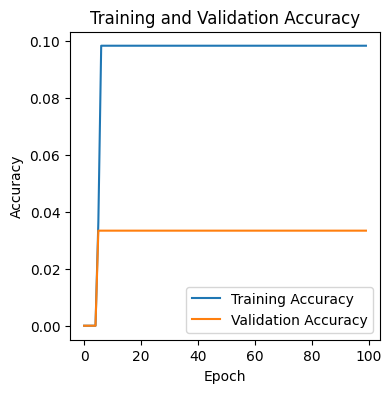

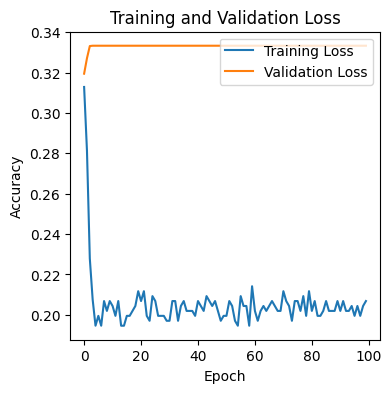

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
print("Evaluate on test data")
results = model.evaluate(test_dataset, label_test)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.0667 - loss: 0.2667
test loss, test acc: [0.2666666805744171, 0.06666667014360428]
